# COVID-19 in Australia (from Wikipedia)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-set-up" data-toc-modified-id="Python-set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python set-up</a></span><ul class="toc-item"><li><span><a href="#other-useful-information" data-toc-modified-id="other-useful-information-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>other useful information</a></span></li></ul></li><li><span><a href="#Scrape-Australian-cumulative-data-from-Wikipedia" data-toc-modified-id="Scrape-Australian-cumulative-data-from-Wikipedia-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scrape Australian cumulative data from Wikipedia</a></span><ul class="toc-item"><li><span><a href="#Data-extraction-/-transformation" data-toc-modified-id="Data-extraction-/-transformation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data extraction / transformation</a></span></li><li><span><a href="#Report-on-data-extraction" data-toc-modified-id="Report-on-data-extraction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Report on data extraction</a></span></li></ul></li><li><span><a href="#Normal-and-semilog-plot-of-cumulative-by-state" data-toc-modified-id="Normal-and-semilog-plot-of-cumulative-by-state-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normal and semilog plot of cumulative by state</a></span><ul class="toc-item"><li><span><a href="#Produce-plots" data-toc-modified-id="Produce-plots-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Produce plots</a></span></li></ul></li><li><span><a href="#Total-bar-charts---most-recent-day" data-toc-modified-id="Total-bar-charts---most-recent-day-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Total bar charts - most recent day</a></span><ul class="toc-item"><li><span><a href="#bar-chart---cumulative-cases" data-toc-modified-id="bar-chart---cumulative-cases-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>bar chart - cumulative cases</a></span></li><li><span><a href="#bar-chart---cumulative-cases-per-capita" data-toc-modified-id="bar-chart---cumulative-cases-per-capita-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>bar chart - cumulative cases per capita</a></span></li><li><span><a href="#Produce-the-bar-charts" data-toc-modified-id="Produce-the-bar-charts-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Produce the bar charts</a></span></li></ul></li><li><span><a href="#Chart-new-and-cumulative-cases" data-toc-modified-id="Chart-new-and-cumulative-cases-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Chart new and cumulative cases</a></span><ul class="toc-item"><li><span><a href="#Produce-the-daily-new/cum-charts" data-toc-modified-id="Produce-the-daily-new/cum-charts-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Produce the daily new/cum charts</a></span></li></ul></li><li><span><a href="#Plot-new-cases:-raw-and-smoothed" data-toc-modified-id="Plot-new-cases:-raw-and-smoothed-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot new cases: raw and smoothed</a></span></li><li><span><a href="#Growth-factor" data-toc-modified-id="Growth-factor-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Growth factor</a></span></li><li><span><a href="#Regional-per-capita" data-toc-modified-id="Regional-per-capita-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Regional per capita</a></span></li><li><span><a href="#Recent" data-toc-modified-id="Recent-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Recent</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python set-up

In [1]:
# imports
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
import matplotlib.dates as mdates
import matplotlib.units as munits
import datetime
from pathlib import Path

# local imports
sys.path.append(r'../bin')
import plotstuff as ps

#pandas
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# scraping
import datetime
import requests
from bs4 import BeautifulSoup

# plotting
plt.style.use('ggplot')
%matplotlib inline

### other useful information

In [2]:
# state information
AU_COLOURS = ['#dd0000', 'darkorange', 'gold', 'seagreen',
              'dodgerblue', 'blue', 'mediumorchid', 'hotpink',
              '#555555']  

AUSTRALIA = 'Australia'
state_pop = {
    # source: https://www.abs.gov.au/statistics/people/population/national-state-and-territory-population/latest-release
    # population at 30 June 2020
    'NSW': 8_164_100,
    'VIC': 6_694_900,
    'QLD': 5_174_400,
    'SA':  1_769_300,
    'WA':  2_661_900,
    'TAS':   540_600,
    'ACT':   431_100,
    'NT':    246_000,
}

N_STATES = len(state_pop)
state_pop = pd.Series(state_pop).sort_values()
state_names = state_pop.index.to_list()[::-1]
state_pop[AUSTRALIA] = state_pop.sum()

# save location
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!AS1-'

# Source
SOURCE = 'Source: Wikipedia'

# exclude today
EXCLUDE_TODAY = True

## Scrape Australian cumulative data from Wikipedia

In [3]:
def scrape_wiki_data():
    
    # get cases
    url = 'https://en.wikipedia.org/wiki/Template:2019%E2%80%9320_coronavirus_pandemic_data/Australia_medical_cases'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            cases = pd.read_html(table.prettify(), header=0, index_col=0)[0]
            break
            
    # get deaths
    url = 'https://en.wikipedia.org/wiki/Template:COVID-19 pandemic data/Australia deaths'
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'lxml')
    tables = soup.findAll('table')
    for table in tables:
        if table.findParent("table") is None:
            deaths = pd.read_html(table.prettify(), header=1, index_col=0)[0]
            break

    return cases, deaths

#cases, deaths = scrape_wiki_data()
#print(deaths)

In [4]:
def common_cleaning(df: pd.DataFrame, mode: str) -> pd.DataFrame:
    
    # 5. make numeric
    df = df.astype(float)

    # 6. make the index a DatetimeIndex
    #    expand to all days
    new_year = df.index[df.index.str.contains('1 January')]
    base = 0;
    year = 2020
    index = 0
    series = pd.Series(df.index, index=df.index)
    while index < len(new_year):
        y = df.index.get_loc(new_year[index])
        series.iloc[base:y] = series.iloc[base:y] + ' ' + str(year)
        year += 1
        index += 1
        base = y
    series.iloc[base:] = series.iloc[base:] + ' ' + str(year)
    match = series.str.contains(r'\d\d\d\d \d\d\d\d', regex=True)
    series[match] = series[match].str.replace(r' \d\d\d\d$', '', regex=True)
    df.index = pd.DatetimeIndex(series).date
    latest = df.index[-1]

    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx, fill_value=np.nan)
    df = df.where(df > 0, other=np.nan).ffill().fillna(0)#.astype(int)
    
    # 7. if the last row is incomplete, drop it
    if df[['NSW', 'VIC', 'QLD', 'WA', 
           'SA', 'TAS', 'ACT', 'NT']].iloc[-1].isna().any():
        print('Dropping last day')
        df = df[:-1]
    
    # reindex (to PeriodIndex)
    today = datetime.datetime.today().date()
    yesterday = pd.Timestamp((today - datetime.timedelta(days=1))).date()
    if EXCLUDE_TODAY:
        if yesterday > latest:
            latest = yesterday
    else:
        if today > latest:
            latest = today
    idx = pd.date_range(df.index.min(), latest)
    df = df.reindex(idx, fill_value=np.nan).ffill()
    
    # 8. make sure it is in date order
    df = df.sort_index()
    
    # --- save it, just to be sure - you never know 
    #     when Wikipedia will stop making this available
    SAVE_DIRECTORY = '../saved_AU_data'
    Path(SAVE_DIRECTORY).mkdir(parents=True, exist_ok=True)
    for_saving = df.copy()
    filename = f'{SAVE_DIRECTORY}/Australia-{mode}-{latest}.csv'
    for_saving.to_csv(filename)
    
    return df

In [5]:
def clean_wiki_cases(df):    
    # --- clean-up what we scraped - very tedious
    #     as this table is very messy - fragile
    #     as Wikipedia constantly changes its layout
    #     and format.

    # 1. get rid of footnotes from column names, etc.
    df.columns = (df.columns.str.replace('\[.*\]', '')
                  .str.replace('  ', ' ')
                  .str.strip())
    df.index = df.index.str.replace('\[.*\]', '')

    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates
    df = df[~df.index.str.contains('Values')]
    df = df[~df.index.str.contains('Notes')]


    # 3. remove footnotes from specified columns
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    for c in df.columns:
        df[c] = (df[c].str.replace('\[.*\]', '').str.strip())
        df[c] = df[c].str.replace(',', '')

    # 4. remove '%' text from specified columns
    cols = ['% growth']
    for c in cols:
        df[c] = (df[c].str.replace('\%', '')
                 .str.strip().astype(float))

    df = common_cleaning(df, 'cases')
    
    return df

In [6]:
def clean_wiki_deaths(df):
    
    # 1. delete reference column
    if 'Ref.' in df.columns:
        del df['Ref.']
    if 'Reference' in df.columns:
        del df['Reference']
    
    # 2. remove nan and other rows
    df = df[df.index.notna()]
    df = df[df.index.str.contains('[0-9]')] # not dates

    df = common_cleaning(df, 'deaths')

    return df

In [7]:
def scrape_and_clean_data():
    cases, deaths = scrape_wiki_data()
    cases = clean_wiki_cases(cases)
    deaths = clean_wiki_deaths(deaths)
    
    return cases, deaths

### Data extraction / transformation

In [8]:
# reference points
RAW_CUM = 0
RAW_DAILY = 1
COOKED_DAILY = 2
COOKED_CUM = 3

QUALITY = 'quality'

# build the data
raws = scrape_and_clean_data()
MODES = ['cases', 'deaths']
data = {}
for mode, raw in zip(MODES, raws):
    
    # process the data for outlires
    raw = raw[raw.columns[:N_STATES]]
    processed = ps.dataframe_correction(raw, verbose=False)
    data[mode] = [raw] + list(processed)
    
    # record if this changed the data
    quality = {}
    for state in raw.columns:
        if (data[mode][RAW_DAILY][state] == 
            data[mode][COOKED_DAILY][state]).all():
            quality[state] = 'Original data'
        else:
            quality[state] = 'Extreme outliers have been adjusted'
    data[mode+QUALITY] = quality

<ipython-input-5-376c82fa0e3d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = (df.columns.str.replace('\[.*\]', '')
<ipython-input-5-376c82fa0e3d>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('\[.*\]', '')
<ipython-input-5-376c82fa0e3d>:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df[c] = (df[c].str.replace('\[.*\]', '').str.strip())
<ipython-input-5-376c82fa0e3d>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df[c] = (df[c].str.replace('\%', '')


### Report on data extraction

In [9]:
for mode in MODES:
    print(mode)
    display(data[mode][RAW_CUM].iloc[-3:])

cases


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
2021-02-27,5172.0,20481.0,1329.0,913.0,613.0,234.0,118.0,105.0
2021-02-28,5177.0,20481.0,1329.0,913.0,613.0,234.0,118.0,105.0
2021-03-01,5180.0,20481.0,1331.0,913.0,616.0,234.0,118.0,105.0


deaths


,NSW,VIC,QLD,WA,SA,TAS,ACT,NT
2021-02-26,54.0,820.0,6.0,9.0,4.0,13.0,3.0,0.0
2021-02-27,54.0,820.0,6.0,9.0,4.0,13.0,3.0,0.0
2021-02-28,54.0,820.0,6.0,9.0,4.0,13.0,3.0,0.0


## Normal and semilog plot of cumulative by state

In [10]:
def semilog_plot(states_data, mode):
    
    power = 6
    pop_factor = int(10 ** power)

    for per_capita in [False, True]:
        
        if per_capita:
            states_data = states_data / state_pop * pop_factor
            states_data = states_data[state_names]
            title = f' per $10^{power}$ pop'
            filename = '-per-capita'
            
        else:
            title = ''
            filename= ''
    
        ax = plt.subplot()
        ax.margins(0.01)
        ax.xaxis_date()

        for i, name in enumerate(states_data.columns):
            ax.plot(states_data[name].index, 
                    states_data[name], lw=2, 
                    color=AU_COLOURS[i], label=name)

        ax.legend(loc='best', ncol=2)

        ps.finalise_plot(ax, 
                         title= 'Cumulative COVID19 '
                               f'{mode.title()}{title}',
                         xlabel=None,
                         ylabel=f'{mode.title()}{title}',
                         chart_directory=CHART_DIRECTORY,
                         rfooter=SOURCE,
                         dont_close=True,
                         show=True,
                        )

        ps.finalise_plot(ax, 
                         title= 'Cumulative COVID19 '
                                f'{mode.title()}{title} (log scale)',
                         xlabel=None,
                         ylabel=f'{mode.title()}{title} (log scale)',
                         yscale='log',
                         chart_directory=CHART_DIRECTORY,
                         rfooter=SOURCE,
                         display=True,
                        )

### Produce plots

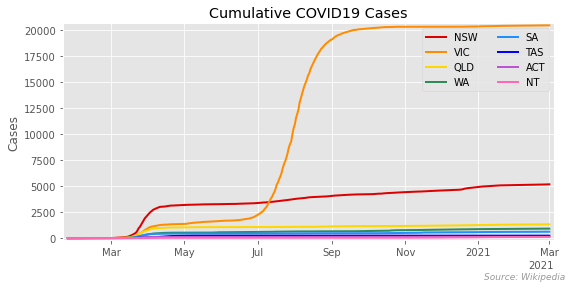

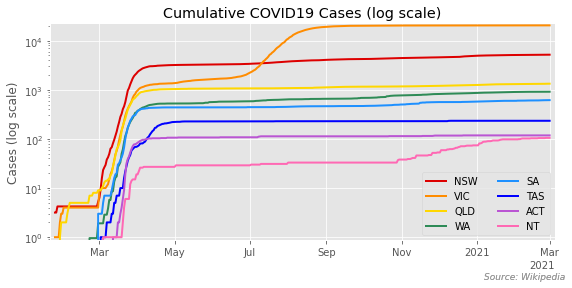

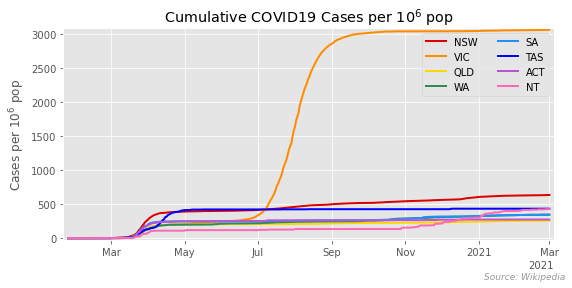

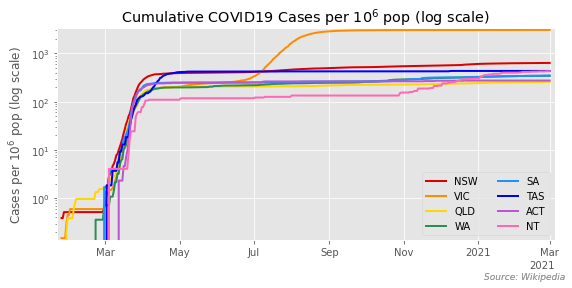

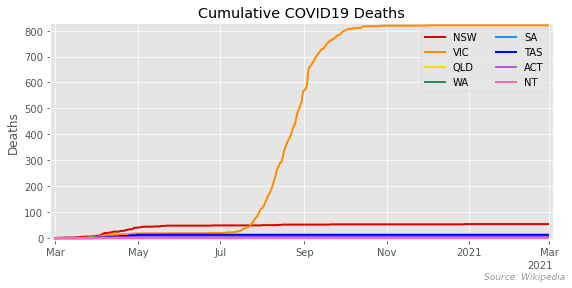

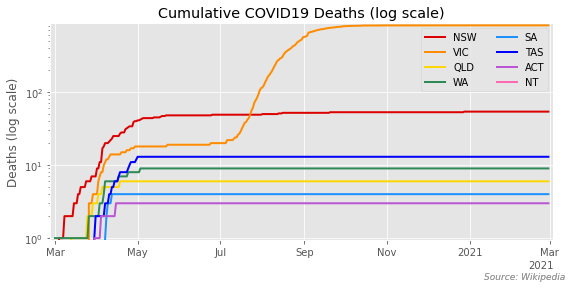

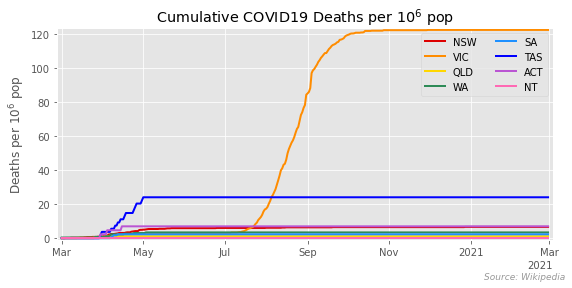

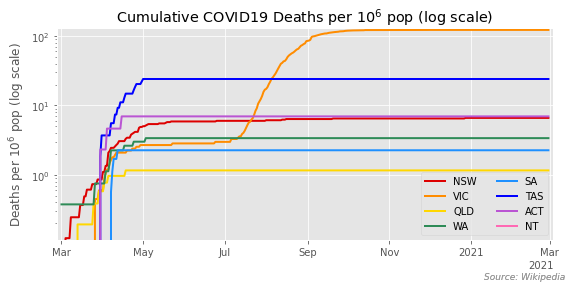

In [11]:
for mode in MODES:
    semilog_plot(data[mode][COOKED_CUM].copy(), 
                 mode, 
                )

## Total bar charts - most recent day

### bar chart - cumulative cases

In [12]:
def bar_chart_cumulative(states_data, mode):
    states_data[AUSTRALIA] = states_data.sum(axis=1)
    latest = states_data.iloc[-1]
    date = states_data.index[-1].ctime()[:10]
    latest = latest.sort_values()
    ps.plot_barh(latest, 
        title=f'Cumulative COVID19 {mode.title()}: Australian States',
        save_as = f'{CHART_DIRECTORY}!bar-chart-cumulative-{mode}.png',
        rfooter=SOURCE + ' ' + date,
        show=True,
    )
    return (latest, date)

### bar chart - cumulative cases per capita

In [13]:
def bar_chart_cum_per_capita(latest, mode, date):
    power = 6
    pop_factor = int(10 ** power)
    latest = (latest / state_pop) * pop_factor
    latest = latest[state_pop.index].round(2) # pop order
    ps.plot_barh(latest, 
                 title=f'Cumulative COVID19 {mode.title()} per '
                       f'$10^{power}$ pop: Australian States',
                 save_as = f'{CHART_DIRECTORY}!bar-chart-per-'
                           f'capita-cumulative-{mode}.png',
                 rfooter=SOURCE + ' ' + date,
                 show=True,
                )

### Produce the bar charts

In [14]:
if False: # Switch: Turn this ouput on or off
    
    for mode in MODES:
        latest, date = bar_chart_cumulative(data[mode][RAW_CUM].astype(int), 
                             mode, 
                            )
        bar_chart_cum_per_capita(latest, mode, date)

## Chart new and cumulative cases

In [15]:
def plot_new_and_cum_cases(states_new, states_cum, mode, data_quality):
    states_cum = states_cum.T
    previous = states_cum.columns.min() - pd.DateOffset(days=1)
    states_cum[previous] = 0
    states_cum = states_cum.T.sort_index()

    for name in states_cum.columns:
        ps.plot_new_cum(
            states_new[name].copy(), 
            states_cum[name].copy(), 
            mode, 
            name,
            'day',
            title=f'{name} COVID-19 {mode.title()}',
            rfooter=data_quality[name],
            chart_directory=CHART_DIRECTORY+'-!daily-',
            save_tag="-daily",
            show=True,
        )

### Produce the daily new/cum charts

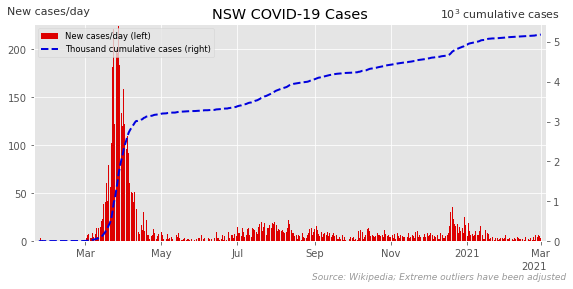

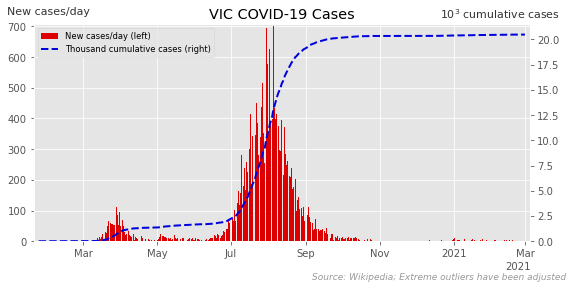

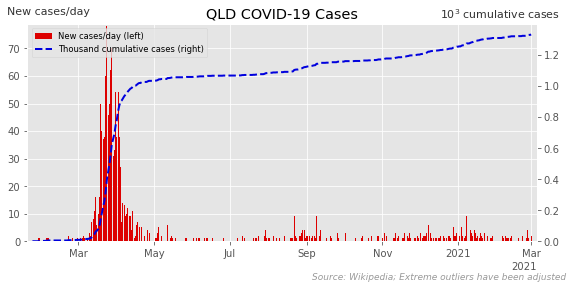

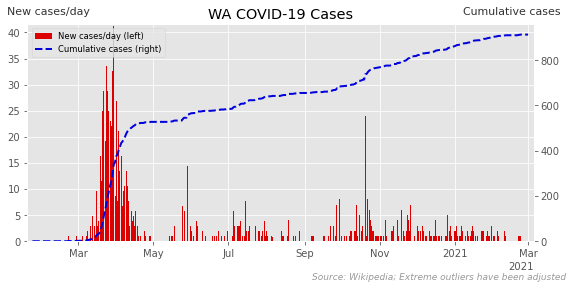

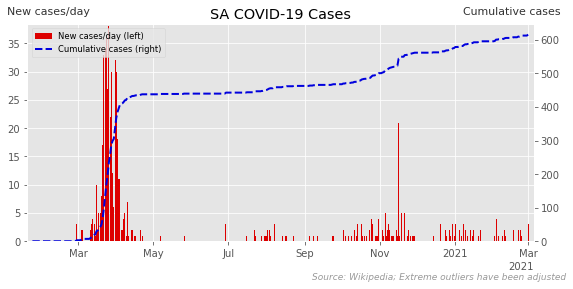

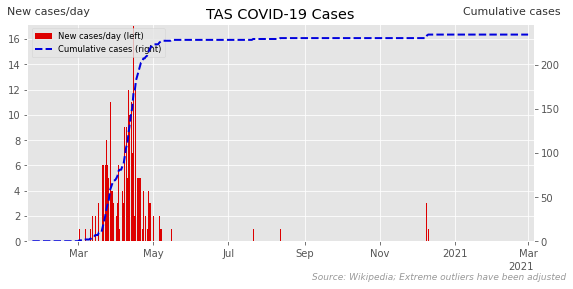

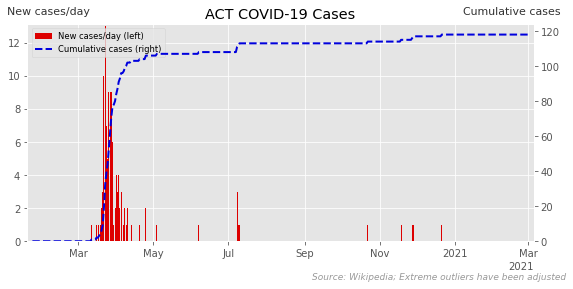

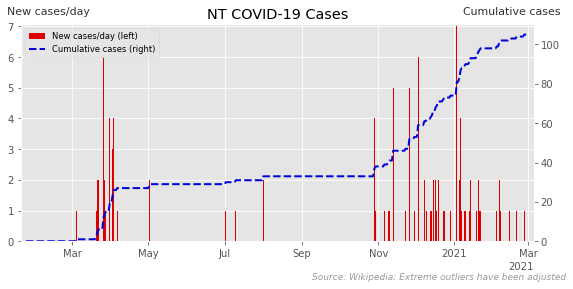

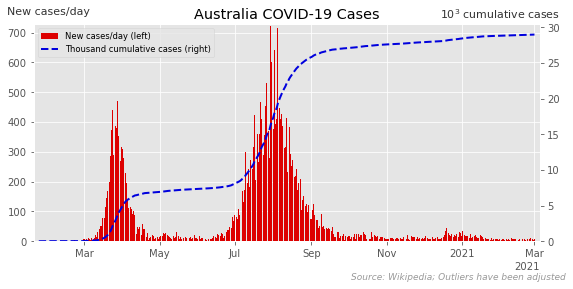

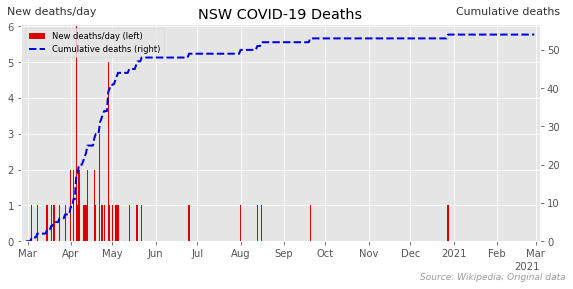

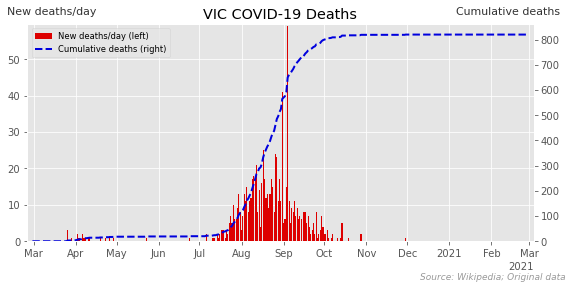

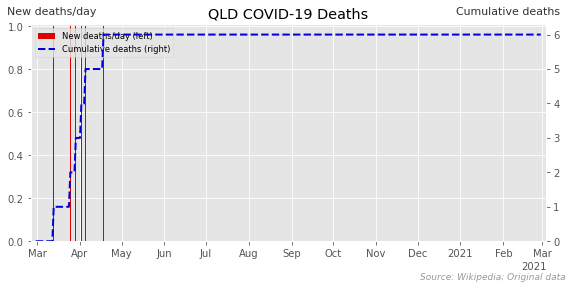

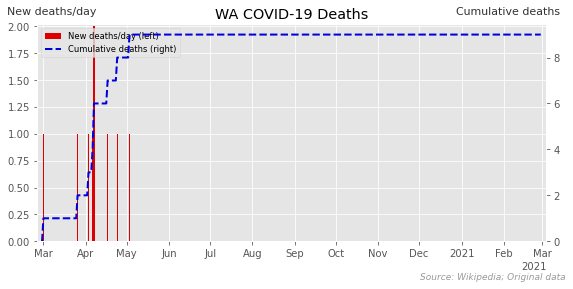

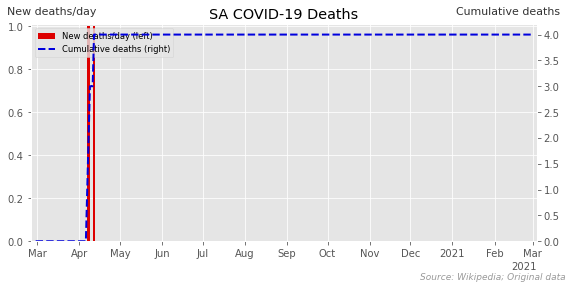

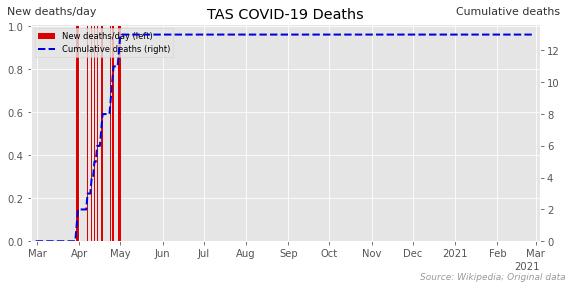

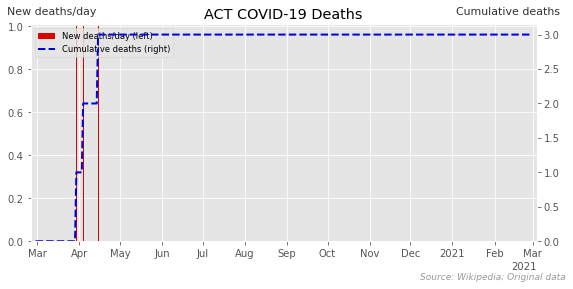

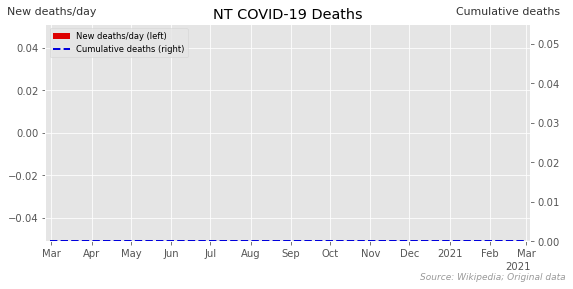

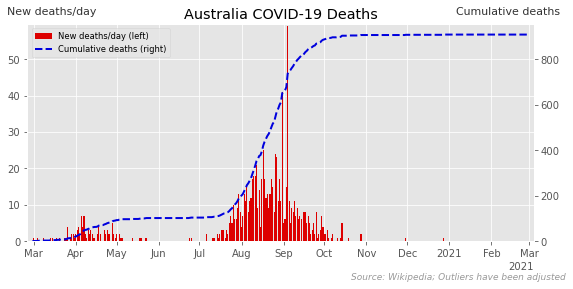

In [16]:
for mode in MODES:
    cum = data[mode][COOKED_CUM].copy()
    cum['Australia'] = cum.sum(axis=1)
    
    new = data[mode][COOKED_DAILY].copy()
    new['Australia'] = new.sum(axis=1)
    
    quality = data[mode+QUALITY].copy()
    for state in quality:
        quality[state] = (SOURCE + '; ' +
                          quality[state])
    quality['Australia'] = (SOURCE + '; ' +
                            'Outliers have been adjusted')

    plot_new_and_cum_cases(new, cum, mode, quality)


## Plot new cases: raw and smoothed

In [17]:
def plot_new_original_smoothed(states_new, mode):
    HMA = 15
    smooth_all = pd.DataFrame()
    rolling_all = pd.DataFrame()
    for name in states_new.columns:
        smooth_all[name] = ps.plot_orig_smooth(states_new[name], 
            HMA, 
            mode,
            'Australia', 
            title=f'Daily New {mode.title()} in {name}', 
            ylabel=f'New {mode} per day',
            rfooter=SOURCE,
            save_as=f'{CHART_DIRECTORY}new-{mode}-chart-{name}.png'

        )
        rolling_all[name] = states_new[name].rolling(7).mean()

    # latest per-captia comparison 
    power = 6
    pop_factor = int(10 ** power)
    latest = rolling_all.iloc[-1]  
    latest = (latest / state_pop) * pop_factor
    latest = latest[state_pop.index].round(2) # pop order
    ps.plot_barh(latest,
        title=f'Daily New COVID19 {mode.title()} (7 day ave.) per $10^{power}$ pop.',
        save_as=f'{CHART_DIRECTORY}bar-chart-per-capita-new-{mode}.png',
        rfooter=SOURCE,
        show=True,
    )

## Growth factor

In [18]:
def plot_growth_factor(states_new, mode):
    for name in states_new.columns:
        ps.plot_growth_factor(states_new[name], 
            title=f'Week on Week Growth - New COVID-19 {mode.title()} in {name}',
            ylabel='Growth factor',
            xlabel=None,
            save_as=f'{CHART_DIRECTORY}growth-chart-{name}-{mode}.png',
            rfooter=SOURCE,
            lfooter=f'Weekly rolling average daily new {mode.lower()} this week / last week',
            show=True,
        )

## Regional per capita

In [19]:
def regional(df, mode):

    if 'Total' in df:
        del df['Total']
        
    regions = {
        'Australia': ['NSW', 'VIC', 'QLD', 'WA', 'SA', 'TAS', 'ACT', 'NT'],
    }
    
    #old = plt.rcParams['axes.prop_cycle'].by_key()['color']
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=AU_COLOURS)
    
    ps.plot_regional_per_captia(
        df[regions['Australia']], mode, regions, state_pop, 
        title=f'State per capita {mode.title()}',
        rfooter=SOURCE,
        chart_directory=CHART_DIRECTORY,
        show=True,
    )

## Recent

In [20]:
def recent(df, mode):
    RECENT = 62 # days
    MA1 = 7 # days
    MA2 = 14 # dats
    plt.style.use('ggplot')
    
    for col in df.columns:
        series = df[col]
        
        if series.iloc[-RECENT:].sum() <= 0: 
            continue
        ma1 = series.rolling(MA1).mean()
        ma2 = series.rolling(MA2).mean()
        
        MARGINS = 0.01
        fig, ax = plt.subplots()
        ax.xaxis_date()
        ax.margins(MARGINS) # seems to work here
        
        #series.iloc[-RECENT:].plot.
        ax.bar(series.iloc[-RECENT:].index.values, series.iloc[-RECENT:], label=mode, color='#dd0000')
        ax.plot(ma1.iloc[-RECENT:].index.values, ma1.iloc[-RECENT:], label=f'{MA1} day ave.', color='darkorange')
        ax.plot(ma2.iloc[-RECENT:].index.values, ma2.iloc[-RECENT:], label=f'{MA2} day ave.', color='cornflowerblue')
        ax.legend(loc='best')
        title = f'Recent New COVID19 {mode.title()} in {col} '
        ps.finalise_plot(ax, title=title,
                         ylabel=f'Daily New COVID {mode.title()}',
                         rfooter=SOURCE,
                         chart_directory=CHART_DIRECTORY,
                         show=True,
                        )

## The End

In [21]:
print('Finished')

Finished
